# Importing libs

In [ ]:
import os
import librosa
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fftpack import dct
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers;

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis


## Creating dataframe

In [241]:
base_path = "TinySOL/"
instruments_type = ["Brass", "Keyboards", "Strings", "Winds"]
instruments = [
    ["Trombone", "Bass_Tuba", "Horn", "Trumpet_C"],
    ["Accordion"],
    ["Violin", "Contrabass", "Viola", "Violoncello"],
    ["Flute", "Bassoon", "Clarinet_Bb", "Flute", "Oboe", "Sax_Alto"]
]

instruments_df = []


for instrument_type, s_instrument in zip(instruments_type, instruments):
    for instrument in s_instrument:
        full_path = os.path.join(base_path, instrument_type, instrument, "ordinario/")
        note_value = []
        qct_frequencies_per_note = []

        df_instrument = {
            'instrument_name': instrument
        }
        print(full_path)
        
        for file in os.listdir(full_path):
            if file.endswith(".wav"):
                note = file.split('-')[2]
                wav_path = os.path.join(full_path, file)
                y, sr = librosa.load(wav_path, sr=None)
                cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

                cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

                frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))
                top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:12]
                top_frequencies = frequencies[top_indices]

                note_value.append(note)
                qct_frequencies_per_note.append(top_frequencies)

        df_instrument['note'] = note_value
        df_instrument['frequencies'] = qct_frequencies_per_note
        df_instrument = pd.DataFrame(df_instrument)
        instruments_df.append(df_instrument)

instruments_df = pd.concat(instruments_df, ignore_index=True)


TinySOL/Brass/Trombone/ordinario/
TinySOL/Brass/Bass_Tuba/ordinario/
TinySOL/Brass/Horn/ordinario/
TinySOL/Brass/Trumpet_C/ordinario/
TinySOL/Keyboards/Accordion/ordinario/
TinySOL/Strings/Violin/ordinario/
TinySOL/Strings/Contrabass/ordinario/
TinySOL/Strings/Viola/ordinario/
TinySOL/Strings/Violoncello/ordinario/
TinySOL/Winds/Flute/ordinario/
TinySOL/Winds/Bassoon/ordinario/
TinySOL/Winds/Clarinet_Bb/ordinario/
TinySOL/Winds/Flute/ordinario/
TinySOL/Winds/Oboe/ordinario/
TinySOL/Winds/Sax_Alto/ordinario/


# Saving dataframe as jsonl

In [242]:
instruments_df.to_json('dataset/dataset.jsonl', orient='records', lines=True)

# Load dataset

In [264]:
instruments_df = pd.read_json('dataset/dataset.jsonl', lines=True)

instruments_df.head()

,instrument_name,note,frequencies
0,Trombone,A#1,"[932.3275230362, 1244.5079348883, 830.60939515..."
1,Trombone,A#1,"[932.3275230362, 830.6093951599, 466.163761518..."
2,Trombone,A#1,"[830.6093951599, 932.3275230362, 466.163761518..."
3,Trombone,A#2,"[932.3275230362, 1396.912925732, 466.163761518..."
4,Trombone,A#2,"[932.3275230362, 466.1637615181, 1396.91292573..."


# Processing dataset
1. Processing missing datas
2. Data Augmentation
3. Balance in terms of instruments 

In [265]:
print(instruments_df["instrument_name"].value_counts())

instrument_name
Accordion      689
Contrabass     309
Viola          309
Violoncello    291
Violin         284
Flute          236
Horn           134
Bassoon        126
Clarinet_Bb    126
Trombone       117
Bass_Tuba      108
Oboe           107
Sax_Alto        99
Trumpet_C       96
Name: count, dtype: int64


In [266]:
def fix_missing_frequencies(frequencies):
    """Funçao responsavel por corrigir as frequências faltantes."""
    freqs = frequencies.copy()

    if len(freqs) < 12:
        # Preencher com a média harmônica das existentes
        harmonic_mean = len(freqs) / sum(1/f for f in freqs if f > 0)
        freqs.extend([harmonic_mean * (1 + 0.05*i) for i in range(12 - len(freqs))])
        print("Achou faltando frequencias")

    if len(freqs) > 12:
        # Truncar a lista para manter apenas as 12 frequências mais altas
        freqs = freqs[:12]
        print("Achou sobrando frequencias")
    return frequencies

In [267]:
instruments_df['frequencies'] = instruments_df['frequencies'].apply(fix_missing_frequencies)

Achou faltando frequencias
Achou faltando frequencias
Achou faltando frequencias


In [268]:
def balance_dataset(df, target_count=600):
    # Separar classes
    class_counts = df['instrument_name'].value_counts()
    
    # Classes > target_count serão reduzidas
    over_classes = class_counts[class_counts > target_count].index.tolist()
    
    # Classes <= targe_count serão aumentadas ou mantidas
    under_classes = class_counts[class_counts <= target_count].index.tolist()
    
    dfs = []
    
    # 1. Redução das classes maiores (undersampling)
    for cls in over_classes:
        sampled = df[df['instrument_name'] == cls].sample(target_count, random_state=42)
        dfs.append(sampled)
    
    # 2. Aumento das classes menores (oversampling + augmentation)
    for cls in under_classes:
        class_df = df[df['instrument_name'] == cls]
        current_count = len(class_df)
        
        if current_count < target_count:
            # Gerar amostras artificiais
            augmented = class_df.copy()
            while len(augmented) < target_count:
                # Técnica de augmentation para frequências
                new_sample = class_df.sample(1).copy()
                new_sample['frequencies'] = new_sample['frequencies'].apply(
                    lambda freqs: [f * np.random.uniform(0.98, 1.02) for f in freqs]  # ±2% de variação
                )
                augmented = pd.concat([augmented, new_sample])
            
            dfs.append(augmented.sample(target_count, random_state=42))
        else:
            dfs.append(class_df)
    
    return pd.concat(dfs, ignore_index=True).sample(frac=1, random_state=42)  # Shuffle final

In [269]:
df_balanced = balance_dataset(instruments_df)
df_balanced['instrument_name'].value_counts()

instrument_name
Accordion      600
Clarinet_Bb    600
Flute          600
Bassoon        600
Trombone       600
Viola          600
Sax_Alto       600
Horn           600
Trumpet_C      600
Contrabass     600
Violin         600
Oboe           600
Violoncello    600
Bass_Tuba      600
Name: count, dtype: int64

## Aux Functions

In [272]:
def get_enhanced_features(frequencies):
    """
    Função ampliada para extração de features
    log_mean: Calcula a media logaritmica das frequências
    skewness: Medida de assimetria das frequências
    kurtosis: Medida de achatamento das frequências
    harmonic_mean: Média harmônica das frequências
    harmonic_std: Desvio padrão harmônico das frequências
    n_harmonics: Número de harmônicos
    freq_0, freq_1, ..., freq_11: Frequências individuais
    """

    freq = sorted([float(f) for f in frequencies])
    fundamental = freq[0] if len(freq) > 0 else 0
    
    # Features básicas
    stats = {
        'log_mean': np.log(np.mean(freq)) if np.mean(freq) > 0 else 0,
        'skewness': skew(freq) if len(freq) > 2 else 0,
        'kurtosis': kurtosis(freq) if len(freq) > 3 else 0
    }
    
    # Features harmônicas

    harmonics = [f/fundamental for f in freq[1:] if f > 0]
    stats.update({
        'harmonic_mean': np.mean(harmonics) if harmonics else 0,
        'harmonic_std': np.std(harmonics) if harmonics else 0,
        'n_harmonics': len(harmonics)
    })

    # Adiciona as 12 frequências originais como features individuais
    for i in range(12):
        stats[f'freq_{i}'] = freq[i] if i < len(freq) else 0
        
    return stats
    


def create_features_instruments(df):
    """
    Processa um DataFrame com colunas: instrument_name, note, frequencies
    Retorna features estatísticas e o target codificado
    
    Parâmetros:
    df : DataFrame com colunas ['instrument_name', 'note', 'frequencies']
    
    Retorna:
    X : DataFrame com features
    y : Série com target codificado
    le : LabelEncoder ajustado
    """

    # Extração de features
    df_stats = df["frequencies"].apply(get_enhanced_features).apply(pd.Series)
    
    # Junção com os dados originais
    df = pd.concat([df, df_stats], axis=1).dropna()
    
    # Codificação do target
    le = LabelEncoder()
    df["instrument_encoded"] = le.fit_transform(df["instrument_name"])
    
    # Seleção automática de features numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [col for col in numeric_cols if col not in ['instrument_encoded']]
    
    return df[features], df["instrument_encoded"], le

## Training the models 

In [273]:

X, y, le = create_features_instruments(df_balanced)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Divisão em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Lista de modelos
modelos = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
}

# Rodar todos
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Modelo: {nome}")
    print(f"Acurácia validaçao: {acc:.4f}")
    print("-" * 30)


X shape: (8400, 18)
y shape: (8400,)
Modelo: Random Forest
Acurácia validaçao: 0.7595
------------------------------
Modelo: Decision Tree
Acurácia validaçao: 0.6774
------------------------------
Modelo: Logistic Regression
Acurácia validaçao: 0.3869
------------------------------
Modelo: SVM
Acurácia validaçao: 0.4494
------------------------------


# Choose Random Forest, and gets the best params

In [274]:

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,  # quantas combinações testar
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)
print("Melhores hiperparâmetros:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 108}


In [275]:
# Para validação
y_val_pred = random_search.predict(X_val)
print("Validação:\n", classification_report(y_val, y_val_pred))

# Para teste
y_test_pred = random_search.predict(X_test)
print("Teste:\n", classification_report(y_test, y_test_pred))


Validação:
               precision    recall  f1-score   support

           0       0.92      0.59      0.72       133
           1       0.83      0.84      0.83       117
           2       0.84      0.76      0.80       115
           3       0.84      0.81      0.82       124
           4       0.94      0.88      0.91       115
           5       0.76      0.81      0.78       131
           6       0.69      0.67      0.68       115
           7       0.74      0.83      0.78       111
           8       0.87      0.82      0.84       129
           9       0.62      0.77      0.69       119
          10       0.58      0.73      0.65       116
          11       0.79      0.68      0.73       129
          12       0.73      0.79      0.76       112
          13       0.67      0.70      0.69       114

    accuracy                           0.76      1680
   macro avg       0.77      0.76      0.76      1680
weighted avg       0.77      0.76      0.76      1680

Teste:
      

In [276]:
# Número de classes (instrumentos)
num_classes = len(np.unique(y))
print(f"num_classes: {num_classes}")


# Codificar o target para one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Definir modelo
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # saída com softmax para classificação multiclasse
])

opt = optimizers.Adam(learning_rate = 0.001)
# Compilar
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Treinar
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    verbose=1
)


num_classes: 14
Epoch 1/100


/home/leandrobandeira/Documentos/UFPB/IdentificadorAcorde/.venv/lib64/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1443 - loss: 2.5291 - val_accuracy: 0.2488 - val_loss: 2.1562
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2351 - loss: 2.1465 - val_accuracy: 0.2952 - val_loss: 1.9778
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2796 - loss: 2.0156 - val_accuracy: 0.3423 - val_loss: 1.8605
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2988 - loss: 1.9318 - val_accuracy: 0.3464 - val_loss: 1.7902
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3212 - loss: 1.8701 - val_accuracy: 0.3685 - val_loss: 1.7613
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3443 - loss: 1.7984 - val_accuracy: 0.3744 - val_loss: 1.7319
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3546 - loss: 1.7992 - val_accuracy: 0.3940 - val_loss: 1.7061
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3866 - loss: 1.7284 - val_accuracy: 0.3869


✅ Acurácia final no conjunto de teste: 0.5851190686225891


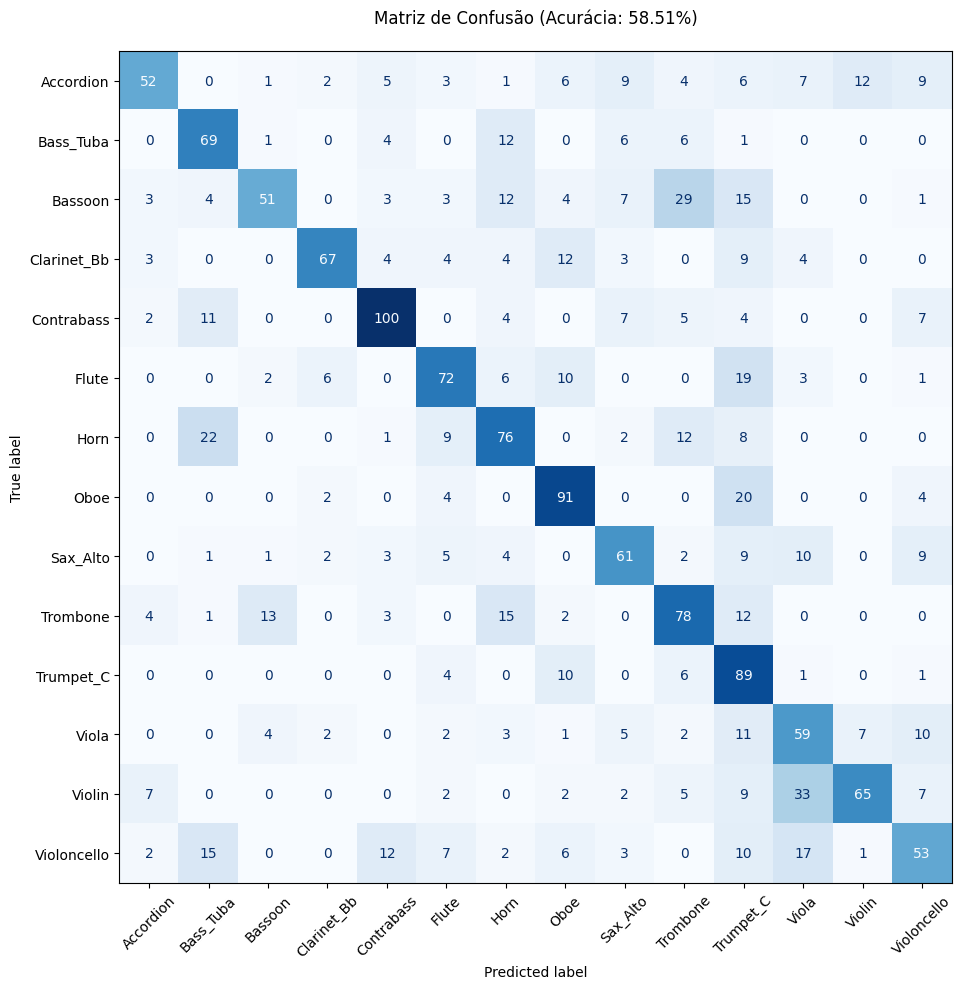

In [277]:
# Avaliar no conjunto de teste
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Acurácia final no conjunto de teste: {acc}")
# 2. Previsões para a matriz de confusão
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte de one-hot para classes
y_true_classes = np.argmax(y_test_cat, axis=1)

# 3. Matriz de confusão
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Plot personalizado
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_  
)
disp.plot(
    cmap='Blues',
    xticks_rotation=45,
    ax=ax,
    values_format='d',
    colorbar=False
)
plt.title(f"Matriz de Confusão (Acurácia: {acc:.2%})", pad=20)
plt.tight_layout()
plt.show()

In [278]:
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_127 (Dense)               │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,692 (155.05 KB)

 Trainable params: 13,230 (51.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,462 (103.37 KB)

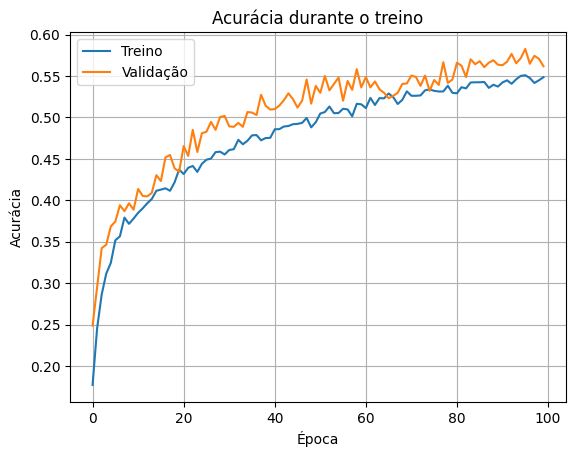

In [279]:


plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()